# Models Comparison for TinyML

In [44]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam


import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import m2cgen as m2c
from micromlgen import port

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

ImportError: cannot import name 'get_config' from 'tensorflow.python.eager.context' (C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\tensorflow_core\python\eager\context.py)

In [33]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.set_random_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [34]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [35]:
X.shape

(500, 32)

In [36]:
labels = 5
samples = 100
X = X[:labels*samples]
y = y[:labels*samples]


In [37]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [39]:
scaler = RobustScaler()

In [40]:
X_test.shape

(100, 32)

## Model Spotting

In [41]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [42]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [43]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_train = scaler.fit_transform(X_cross_train)
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        X_cross_test = scaler.transform(X_cross_test)
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,35 0,06
LR - 0,45 0,07
CART - 0,49 0,07
SVC - 0,61 0,06
RF - 0,63 0,06


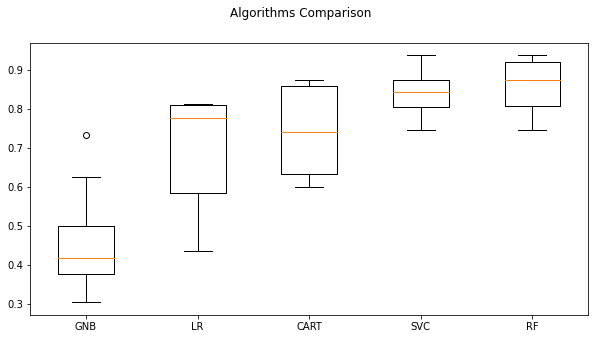

In [29]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione modelli sul Test Set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.67      0.10      0.17        20
           1       0.51      0.95      0.67        20

    accuracy                           0.53        40
   macro avg       0.59      0.53      0.42        40
weighted avg       0.59      0.53      0.42        40

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        20
           1       0.71      0.75      0.73        20

    accuracy                           0.73        40
   macro avg       0.73      0.72      0.72        40
weighted avg       0.73      0.72      0.72        40

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.75      0.75      0.75        20

    accuracy          

# Valutazione Inferance Rate medio (|X_test| = 40)

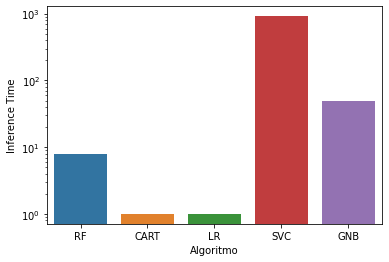

In [30]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

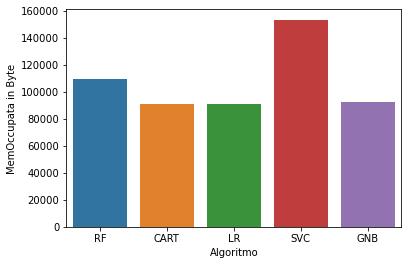

In [15]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Export Models in C code

In [16]:
for name, model in models:
    prepath = 'exportedModels/' + str(labels) + "/"
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))